# New Section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Laod the libraries**

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
import random 
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



**Load the data**

In [3]:
sales = pd.read_csv("/content/drive/My Drive/M5 Forcasting/sales_train_evaluation.csv")
price = pd.read_csv("/content/drive/My Drive/M5 Forcasting/sell_prices.csv")
cal = pd.read_csv("/content/drive/My Drive/M5 Forcasting/calendar.csv")

**data preprocessing**

In [ ]:
#https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling/notebook#2.-Downcasting

def downcast(df):

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df  

In [ ]:
sales = downcast(sales)
cal = downcast(cal)
price = downcast(price)

In [ ]:
for day in range(1942,1970):
  sales['d_' + str(day)] = 0
  sales['d_' + str(day)] = sales['d_' + str(day)].astype(np.int16)

In [ ]:
df_melt = pd.melt(sales, id_vars=[a for a in sales.columns if a.find("id")!=-1],
                           value_vars=[a for a in sales.columns if a.find("d_")==0], var_name='d', value_name='sales')

In [ ]:
df_melt = pd.merge(df_melt, cal, on='d', how='left')
df_melt = pd.merge(df_melt, price, on=['store_id','item_id','wm_yr_wk'], how='left')

In [ ]:
df_melt["sell_price"].fillna(df_melt.groupby("id")["sell_price"].transform("mean"), inplace=True)

In [ ]:
df_melt.drop(columns=["date","weekday"], inplace=True)
df_melt['d'] = df_melt['d'].apply(lambda a: a.split('_')[1]).astype(np.int16)

**features engineering**

In [ ]:
#label encoding features

columns = list(df_melt.columns)
d_types = list(df_melt.dtypes.values)

for a, d_t in enumerate(d_types):
  if d_t.name == 'category':
    df_melt[columns[a]] = df_melt[columns[a]].cat.codes
        

In [ ]:
#lag features

lags = [28, 35, 42, 49, 56, 63, 70, 77]
for lag in tqdm(lags):
  df_melt["lag_" + str(lag)] = df_melt.groupby("id")["sales"].shift(lag).astype(np.float16)

100%|██████████| 8/8 [00:26<00:00,  3.36s/it]


In [ ]:
#rolling median features

df_melt['lag_28'] = df_melt.groupby('id')['sales'].transform(lambda x: x.shift(28))

df_melt['rolling_median_7'] = df_melt.groupby('id')['lag_28'].transform(lambda x: x.rolling(7).median())
df_melt['rolling_median_28'] = df_melt.groupby('id')['lag_28'].transform(lambda x: x.rolling(28).median())
df_melt['rolling_median_50'] = df_melt.groupby('id')['lag_28'].transform(lambda x: x.rolling(50).median())

In [ ]:
df_melt = df_melt[df_melt['d']>1050]
df_melt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70,lag_77,rolling_median_7,rolling_median_28,rolling_median_50
32014500,14370,1437,3,1,0,0,1051,0,11347,1,12,2013,-1,-1,-1,-1,0,0,1,8.257812,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.5,0.0
32014501,14380,1438,3,1,0,0,1051,2,11347,1,12,2013,-1,-1,-1,-1,0,0,1,3.970703,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32014502,14390,1439,3,1,0,0,1051,0,11347,1,12,2013,-1,-1,-1,-1,0,0,1,2.970703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32014503,14400,1440,3,1,0,0,1051,1,11347,1,12,2013,-1,-1,-1,-1,0,0,1,4.640625,2.0,3.0,5.0,8.0,1.0,3.0,5.0,2.0,1.0,2.0,2.0
32014504,14410,1441,3,1,0,0,1051,3,11347,1,12,2013,-1,-1,-1,-1,0,0,1,3.080078,0.0,1.0,3.0,1.0,4.0,3.0,1.0,1.0,0.0,0.0,1.0


In [ ]:
df_melt.isnull().any()

id                   False
item_id              False
dept_id              False
cat_id               False
store_id             False
state_id             False
d                    False
sales                False
wm_yr_wk             False
wday                 False
month                False
year                 False
event_name_1         False
event_type_1         False
event_name_2         False
event_type_2         False
snap_CA              False
snap_TX              False
snap_WI              False
sell_price           False
lag_28               False
lag_35               False
lag_42               False
lag_49               False
lag_56               False
lag_63               False
lag_70               False
lag_77               False
rolling_median_7     False
rolling_median_28    False
rolling_median_50    False
dtype: bool

In [ ]:
df_melt.to_pickle("df_melt")

In [ ]:
df_melt=pd.read_pickle("df_melt")

In [4]:
df_melt = pd.read_pickle("/content/drive/My Drive/M5 Forcasting/df_melt")

In [5]:
df_melt.shape

(28020310, 31)

**train-test split**

In [7]:
X_train = df_melt[df_melt["d"] < 1914].drop("sales", axis=1)
X_val =  df_melt[(df_melt['d']>=1914) & (df_melt['d']<=1941)].drop('sales',axis=1)
X_test = df_melt[df_melt["d"] >= 1942].drop("sales", axis=1)

y_train = df_melt[df_melt["d"] < 1914]["sales"]
y_val = df_melt[(df_melt['d']>=1914) & (df_melt['d']<=1941)]["sales"]

In [8]:
X_train.shape

(26312870, 30)

In [9]:
X_val.shape

(853720, 30)

compute the weights for level 12 series

In [10]:
price["id"] = price["item_id"] + "_" + price["store_id"] + "_evaluation"
cal["d"] = cal["d"].apply(lambda a: int(a.split("_")[1]))

In [11]:
#https://www.kaggle.com/qcw171717/other-naive-forecasts-submission-score/notebook

for day in tqdm(range(1886, 1914)):  
    wk_id = list(cal[cal["d"]==day]["wm_yr_wk"])[0]
    wk_price = price[price["wm_yr_wk"]==wk_id]
    df_sales = sales.merge(wk_price[["sell_price", "id"]], on=["id"], how='inner')
    df_sales["unit_sales_" + str(day)] = df_sales["sell_price"] * df_sales["d_" + str(day)]
    df_sales.drop(columns=["sell_price"], inplace=True)

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


In [12]:
col = [a for a in df_sales.columns if a.find("unit_sales")==0]
df_sales["sales"] = df_sales[col]
df_sales["weight"] = df_sales["sales"] / df_sales["sales"].sum()
df_sales.drop(columns=["sales", col[0]], axis=1, inplace=True)
df_sales["weight"] /= 12

In [13]:
aggregation_level = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 
              6: ["state_id", "cat_id"], 7: ["state_id", "dept_id"], 8: ["store_id", "cat_id"], 9: ["store_id", "dept_id"],
              10: ["item_id"], 11: ["item_id", "state_id"]}

In [14]:
#function to calculate rmsse 

h = 28
n = 1913

def RMSSE(ground_truth, forecast, train_series):
    
    num = ((ground_truth - forecast)**2).sum(axis=1)
    den = 1/(n-1) * ((train_series[:, 1:] - train_series[:, :-1]) ** 2).sum(axis=1)
    rmsse = (1/h * num/den) ** 0.5

    return rmsse

In [15]:
# function to compute custom hyperparametrer tuning

def hyperparameter_tuning(X_train, y_train, model):

    model.fit(X_train, y_train)

    for d in range(1914, 1942):
        df_sales['F_' + str(d)] = model.predict(X_val[X_val['d']==d])
    
    data = df_sales[[a for a in df_sales.columns if a.find("d_") == 0 or a.find("F_") == 0]]
    data = data.sum()

    aggregated_df = pd.DataFrame(data).transpose()    
    aggregated_df["level"] = 1
    aggregated_df["weight"] = 1/12    
    columns = aggregated_df.columns  

    for lev in aggregation_level:
        df_t = df_sales.groupby(by=aggregation_level[lev]).sum().reset_index()
        df_t["level"] = lev
        aggregated_df = aggregated_df.append(df_t[columns])     

    train_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) < 1914]
    actual_value_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) in range(1914, 1942)]
    forecast_value_columns = [a for a in df_sales.columns if a.find("F_") == 0]    

    ground_truth_df = np.array(df_sales[actual_value_columns])
    forecast_df = np.array(df_sales[forecast_value_columns])
    train_series_df = np.array(df_sales[train_columns])

    ground_truth_agg_df = np.array(aggregated_df[actual_value_columns])
    forecast_agg_df = np.array(aggregated_df[forecast_value_columns])
    train_series_agg_df = np.array(aggregated_df[train_columns])

    df_sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_series_df)
    aggregated_df["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_series_agg_df)

    df_sales["wrmsse"] = df_sales["weight"] * df_sales["rmsse"]
    aggregated_df["wrmsse"] = aggregated_df["weight"] * aggregated_df["rmsse"]

    print(df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())
    
    return (df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())

In [ ]:
%%time

wrmsse=[]
lr=[]
n_leaves=[]
min_d_leaf=[]

for _ in tqdm(range(15)):

    learning_rate = random.randint(25, 75)/1000
    num_leaves = random.randint(32, 128)
    min_data_in_leaf = random.randint(50, 150)

    print(learning_rate)
    print(num_leaves)
    print(min_data_in_leaf)
    
    model = lgb.LGBMRegressor(learning_rate= learning_rate,num_leaves=num_leaves,min_data_in_leaf=min_data_in_leaf)
    
    WRMSSE = hyperparameter_tuning(X_train, y_train, model)

    wrmsse.append(WRMSSE)
    lr.append(learning_rate)
    n_leaves.append(num_leaves)
    min_d_leaf.append(min_data_in_leaf)
   


  0%|          | 0/15 [00:00<?, ?it/s]

0.03
106
139



  7%|▋         | 1/15 [03:54<54:37, 234.11s/it]

0.8616449802156569
0.031
35
70



 13%|█▎        | 2/15 [06:57<47:24, 218.78s/it]

0.9137737438358748
0.068
78
109



 20%|██        | 3/15 [10:10<42:13, 211.12s/it]

0.717371937092594
0.035
63
141



 27%|██▋       | 4/15 [13:33<38:16, 208.80s/it]

0.8460583729572915
0.045
86
60



 33%|███▎      | 5/15 [16:59<34:39, 208.00s/it]

0.7813279366764813
0.071
123
147



 40%|████      | 6/15 [20:30<31:18, 208.70s/it]

0.7067169301558276
0.075
95
59



 47%|████▋     | 7/15 [23:42<27:10, 203.83s/it]

0.7116286218121783
0.025
110
124



 53%|█████▎    | 8/15 [27:40<24:58, 214.11s/it]

0.9194683079155135
0.051
71
77



 60%|██████    | 9/15 [30:57<20:53, 208.95s/it]

0.7640327690552523
0.03
88
137



 67%|██████▋   | 10/15 [34:39<17:44, 212.95s/it]

0.8722651953749397
0.064
71
127



 73%|███████▎  | 11/15 [37:53<13:48, 207.17s/it]

0.72746246445814
0.069
94
62



 80%|████████  | 12/15 [41:12<10:13, 204.54s/it]

0.7167816797727539
0.039
101
127



 87%|████████▋ | 13/15 [44:53<06:59, 209.52s/it]

0.7983751072002795
0.025
116
117



 93%|█████████▎| 14/15 [48:53<03:38, 218.68s/it]

0.9138323060393725
0.073
64
119



100%|██████████| 15/15 [52:00<00:00, 208.01s/it]

0.7140471507273172
CPU times: user 3h 21s, sys: 1min 46s, total: 3h 2min 7s
Wall time: 52min


In [ ]:
minpos = wrmsse.index(min(wrmsse))
learning_rate = lr[minpos]
num_leaves = n_leaves[minpos]
min_data_in_leaf = min_d_leaf[minpos]

In [27]:
learning_rate = 0.071
num_leaves = 123
min_data_in_leaf = 147

In [28]:
#fit the model on best parameters

m_lgb = lgb.LGBMRegressor( learning_rate=learning_rate ,
                           num_leaves=num_leaves ,
                           min_data_in_leaf=min_data_in_leaf)

m_lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.071, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=147, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=123, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [29]:
#predict the validation data

for d in range(1914, 1942):
    df_sales['F_' + str(d)] = m_lgb.predict(X_val[X_val['d']==d])

In [30]:
def WRMSSE(df_sales):

  aggregation_level = {2: ["state_id"], 3: ["store_id"], 4: ["cat_id"], 5: ["dept_id"], 
              6: ["state_id", "cat_id"], 7: ["state_id", "dept_id"], 8: ["store_id", "cat_id"], 9: ["store_id", "dept_id"],
              10: ["item_id"], 11: ["item_id", "state_id"]}

  data = df_sales[[a for a in df_sales.columns if a.find("d_") == 0 or a.find("F_") == 0]]
  data = data.sum()

  aggregated_df = pd.DataFrame(data).transpose()    
  aggregated_df["level"] = 1
  aggregated_df["weight"] = 1/12    
  columns = aggregated_df.columns  

  for lev in aggregation_level:
      df_t = df_sales.groupby(by=aggregation_level[lev]).sum().reset_index()
      df_t["level"] = lev
      aggregated_df = aggregated_df.append(df_t[columns])     

  #print(df_sales.shape[0], aggregated_df.shape[0], df_sales.shape[0] + aggregated_df.shape[0])
  #print(aggregated_df["weight"].sum() + df_sales["weight"].sum())    

  train_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) < 1914]
  actual_value_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) in range(1914, 1942)]
  forecast_value_columns = [a for a in df_sales.columns if a.find("F_") == 0]    


  ground_truth_df = np.array(df_sales[actual_value_columns])
  forecast_df = np.array(df_sales[forecast_value_columns])
  train_series_df = np.array(df_sales[train_columns])

  ground_truth_agg_df = np.array(aggregated_df[actual_value_columns])
  forecast_agg_df = np.array(aggregated_df[forecast_value_columns])
  train_series_agg_df = np.array(aggregated_df[train_columns])

  df_sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_series_df)
  aggregated_df["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_series_agg_df)

  df_sales["wrmsse"] = df_sales["weight"] * df_sales["rmsse"]
  aggregated_df["wrmsse"] = aggregated_df["weight"] * aggregated_df["rmsse"]

  print("df", df_sales["wrmsse"].sum())
  print("agg_df",aggregated_df["wrmsse"].sum())

  WRMSSE = df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum()
  #print(WRMSSE)

  return WRMSSE     

In [31]:
WRMSSE(df_sales)


df 0.0871697137234316
agg_df 0.619547216432396


0.7067169301558276

**create submission file**

In [32]:
submit_df1 = df_sales[["id"]]

for d, i in enumerate(range(1914, 1942)):
    submit_df1['F' + str(d+1)] = df_sales["F_" + str(i)]

submit_df1["id"] = submit_df1["id"].apply(lambda x: x.replace('evaluation', 'validation'))    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
submit_df2 = df_sales[["id"]]
for d in range(1, 29):
    submit_df2['F' + str(d)] = m_lgb.predict(X_test[X_test['d']==(1941+d)])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
submit = submit_df1.append(submit_df2).reset_index(drop=True)
submit.to_csv("submission.csv", index=False)

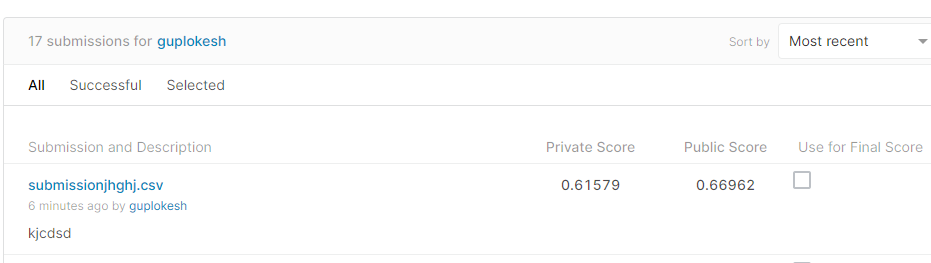

In [36]:
from IPython.display import Image
Image("/content/Screenshot (4855).png")